### Fill in your name, student id number and email address
#### name: Milja Lempinen
#### student id: 520600
#### email: mmlemp@utu.fi

## Data analysis and knowledge discovery - Exercise 4: Unsupervised learning

This is the template for the fourth exercise. The purpose of this exercise is to familiarize yourself with the basics of unsupervised learning by using the agglomerative hierarchical clustering algorithm to find patterns - in this case clusters of ships with the same type - in the data, and then evaluate the performance of the algorithm.


 - As in the two previous exercises, the grading scale is 0 (failed), 50 (passed) and 100 (passed with honors).
 
 - For a passing grade each part of the exercise must be done and questions answered. Some small mistakes can be tolerated but try to avoid any. All of the cells in your submitted notebook should be able to run without errors. Clean up the notebook before submitting it by deleting unnecessary cells and pieces of code for better readability.

 - Remember to comment your code to explain how it works and what it is supposed to do (messy, uncommented and badly written code may contribute to a failing grade).
 
 - Answer the questions asked in the assignments in the markdown cells below the code cells.

 - For doing both the exercise and the optional bonus task sufficiently well, you will be awarded one bonus point (passed with honors).
 
 - If you are having problems with this exercise, try google or stackoverflow first, but do not merely copy-paste any code you may find, since it can be considered plagiarism. (See exercise guidelines in the Moodle page of this course) If you still can't find a solution to your problem, ask for help in the course discussion forum in moodle or contact ilksuu@utu.fi.

### Import all the libraries etc. you need

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA

import sklearn.cluster
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.metrics import adjusted_rand_score

from scipy.cluster.hierarchy import linkage, dendrogram

### Read the data

- Download the exercise 4 data from exercise 4 tab in the Moodle page of this course.
- Read the ship data from the csv file into a Pandas dataframe.
- This file is already cleaned of outliers and missing values etc. Normally data cleaning is an important part of unsupervised learning, but since it has already been done in the previous exercises, we can start this one with already clean data.

In [2]:
data_path = 'shipdata2021_ex4.csv'

data = pd.read_csv(data_path)
data.head()

,MMSI,Speed,COG,Destination,Ship_type,Gross_tonnage,Length,Breadth
0,212209000,10.1377,64.3074,Hamina,Cargo,3416,94.91,15.34
1,212436000,13.5256,77.0755,Hamina,Tanker,6280,116.90,18.00
2,219082000,9.9416,74.6762,Hamina,Tanker,9980,141.20,21.90
3,219083000,11.6038,74.7529,Hamina,Tanker,9980,141.20,21.60
4,219426000,11.9203,56.3253,Hamina,Tanker,3219,99.90,15.00


### Part 1: Preprocess and visualize the data

 - Use "Speed", "COG", "Length", and "Gross_tonnage" as features for this exercise. You will also need the 'Ship_type' -column later to be used as labels for evaluating the performance of the clustering algorithm.
  
 - Perform z-score standardization on the features to ensure that all features have the same scale.
 
 - Project the data to two dimensions by using principal component analysis (PCA) and visualize the resulting two-dimensional data in a scatter plot. Don't color the scatter plot yet. Can you guess where the different ship types are in the scatter plot? Don't worry if they're hard to see.
 
 - The set of features used in this exercise is not necessarily the most sensible from the point of view of real life maritime data-analysis, but rather has been chosen in an ad-hoc manner for the purpose of designing this exercise with a certain level of clustering performance. Consider the features given for now.

In [3]:
standardized_data = pd.DataFrame()

standardized_data['Speed_standardized'] = (data['Speed']-data['Speed'].mean())/data['Speed'].std()
standardized_data['Length_standardized'] = (data['Length']-data['Length'].mean())/data['Length'].std()
standardized_data['Gt_standardized'] = (data['Gross_tonnage']-data['Gross_tonnage'].mean())/data['Gross_tonnage'].std()
standardized_data['COG_standardized'] = (data['COG']-data['COG'].mean())/data['COG'].std()
standardized_data['Ship_type'] = data['Ship_type']

In [4]:
standardized_data.head()

,Speed_standardized,Length_standardized,Gt_standardized,COG_standardized,Ship_type
0,-0.160696,-0.561962,-0.537555,-0.887516,Cargo
1,1.574301,-0.180091,-0.382007,-0.076107,Tanker
2,-0.261122,0.241895,-0.181055,-0.228582,Tanker
3,0.590117,0.241895,-0.181055,-0.223708,Tanker
4,0.752202,-0.475307,-0.548254,-1.394776,Tanker


In [5]:
x = standardized_data.loc[:,'Speed_standardized':'COG_standardized'].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

principal_components_df = pd.DataFrame(data=principal_components, columns = [1,2])
principal_components_df['Labels'] = standardized_data['Ship_type']

print(principal_components_df.head())

          1         2  Labels
0 -0.650190 -0.886333   Cargo
1  0.182936 -0.942072  Tanker
2 -0.011123 -0.081802  Tanker
3  0.279332 -0.480410  Tanker
4 -0.214210 -1.725378  Tanker


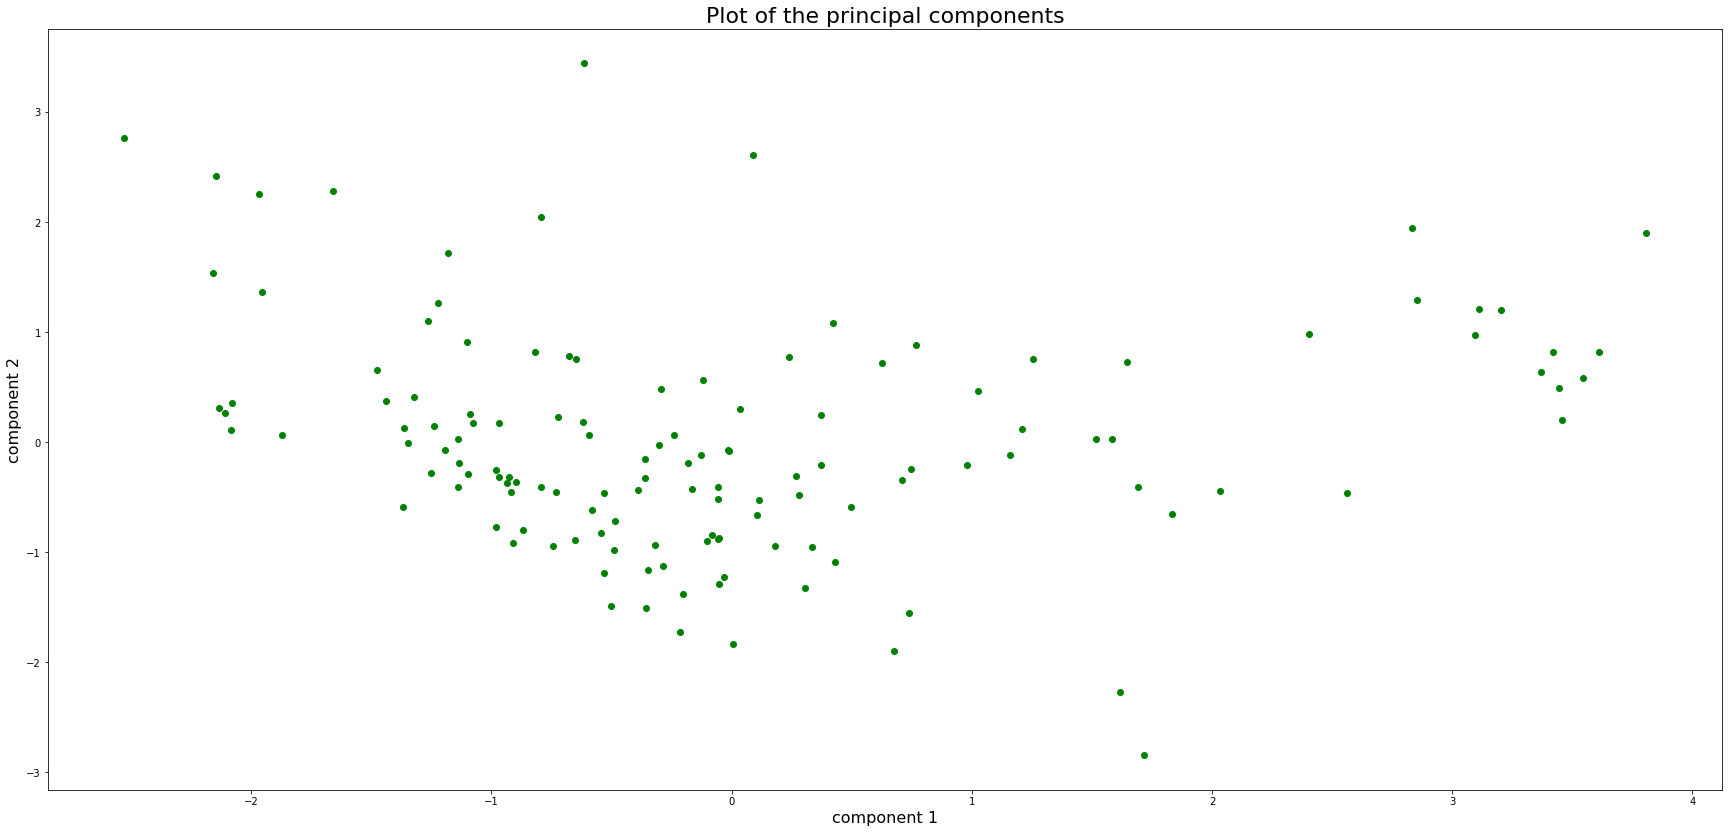

In [6]:
#Without coloring
plt.figure(figsize=(30,14))
plt.title("Plot of the principal components", fontsize=22)
plt.xlabel("component 1", fontsize=16)
plt.ylabel("component 2", fontsize=16)
plt.scatter(principal_components_df[1], principal_components_df[2], color='green')
plt.show()

####  Part 1 : Answers here:

It is quite difficult to distinguisg the different ship types without the colors. We can, however see from here that most of the dots are between -1 & 1, so that could be where the most common ship types are.

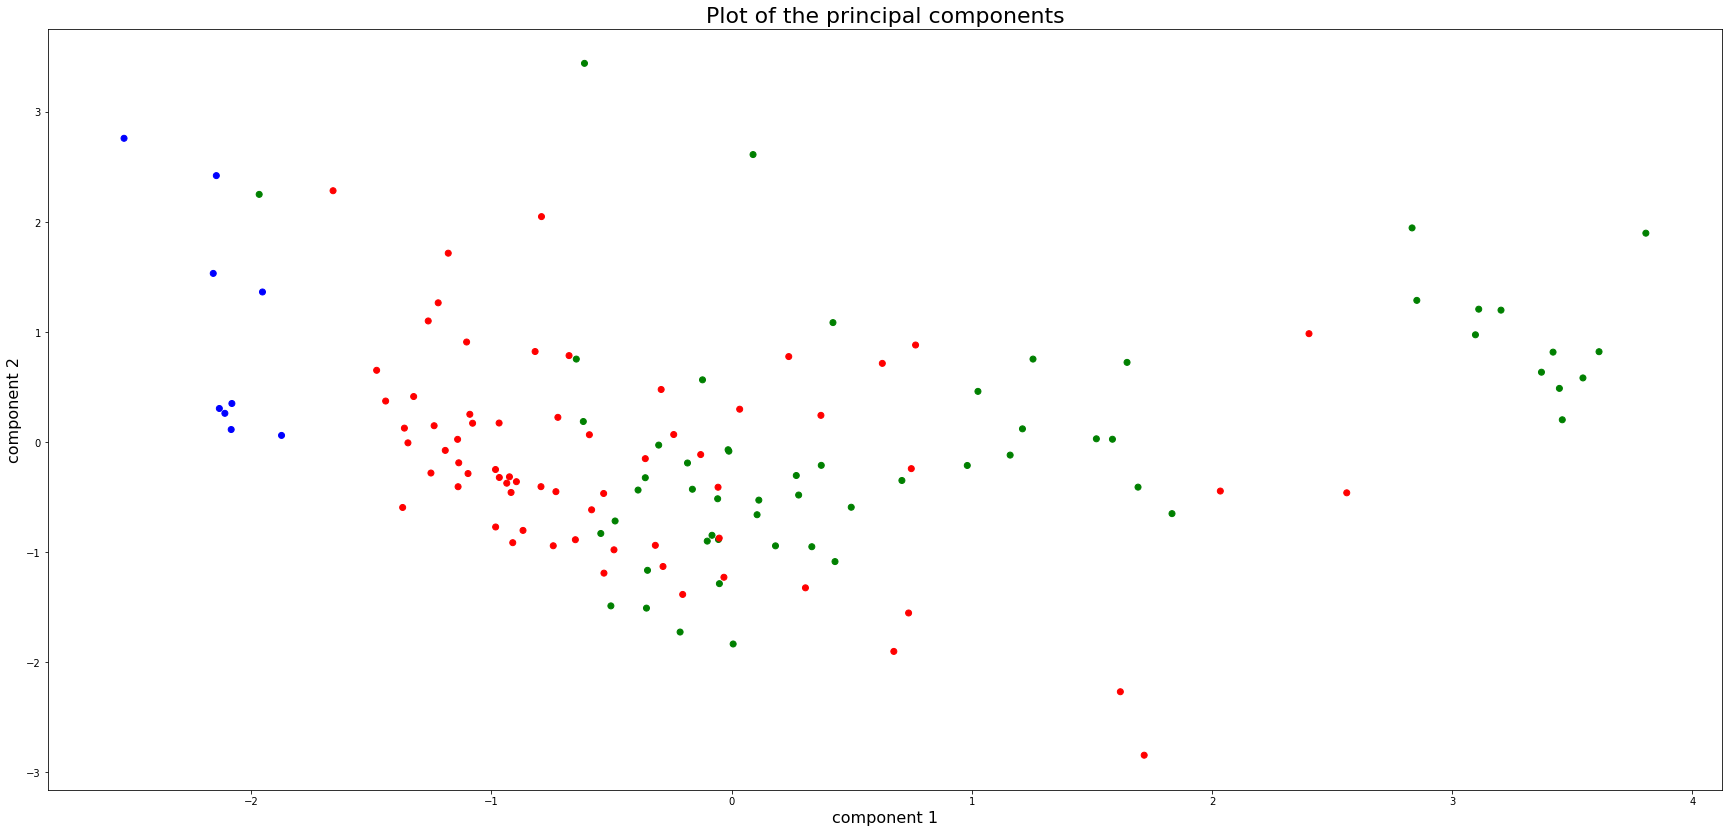

In [7]:
#With coloring by ship type
colors = {'Cargo':'red', 'Tanker':'green', 'Tug':'blue'}

plt.figure(figsize=(30,14))
plt.title("Plot of the principal components", fontsize=22)
plt.xlabel("component 1", fontsize=16)
plt.ylabel("component 2", fontsize=16)
plt.scatter(principal_components_df[1], principal_components_df[2], c=principal_components_df['Labels'].map(colors))
plt.show()

From the newly colored scheme, I can see that I was not completely wrong, but there is clear overlap between two ship types, most likely related to their similarities in size.

### Part 2: Perform clustering on the data and evaluate the results using silhouette score

 - What is the significance of the linkage criterion in a hierarchical clustering algorithm?
 
 - Perform agglomerative hierarchical clustering on the data, trying different values for the "linkage" parameter. Use the actual number of different ship types for the number of clusters to find and default values for other parameters.
 
 - Use the z-score standardized 4-dimensional data for the clustering - not the PCA-transformed data!
 
 - Evaluate the clustering performance for each linkage criterion using a metric called "silhouette score". What does silhouette score quantify and how is it computed?

In [8]:
X = x
linkages = {'ward', 'complete', 'average', 'single'} 
for i in linkages:
    aggcluster = AgglomerativeClustering(n_clusters=3, linkage=i).fit(X)
    labelarray = aggcluster.labels_
    print(str(i)+ ' ' + str(silhouette_score(X, labelarray, labels=3)))

complete 0.26410656210594774
average 0.47142342120337954
single 0.29176878276068163
ward 0.4397650336270209


####  Part 2 : Answers here:

Silhouette score is a way to compute the distance between the predicted label and the The closer the silhuette score is to 1, the better (sklearn.metrics documentation). The linkage with criterion 'average' seems to be the best for our data.

###  Part 3a: Compare the clusters with the true labels
 
 - If you performed the previous steps as instructed, the "average" linkage criterion should be the best performing linkage criterion (that is, with respect to the silhouette score).
 
 - Perform agglomerative hierarchical clustering on the (z-score standardized, not pca-transformed) data using the "average" linkage criterion and the number of different ship types for the number of clusters to find. Again, use default values for other parameters. Visualize the clusters with a scatterplot by performing PCA transformation to two dimensions and color the scatterplot based on the predictions produced by the clustering algorithm. 
 
 - Visualize the data again using PCA, this time coloring the scatter plot based on the true class labels. Compare the two scatter plots: how well do the clusters found by the clustering algorithm match the true classes? Place the two scatter plots so that they can easily be compared (e.g. in subplots next to each other in the same figure).
 
 - Based on the visual comparison between the clusters and true classes, would you say that the clustering was successful?
 
 - Rand score is a measure of similarity between two partitions of a set of elements - in this case true classes and clusters found by the clustering algorithm - and it is one of the most frequently used performance metrics for clustering. It is computed by considering each pair of elements in the dataset and counting pairs of elements as follows:
 
         a: number of pairs such that the elements are in the same class and in the same cluster
         b: number of pairs such that the elements are in different classes and in different clusters
         c: number of pairs such that the elements are in the same class but in different clusters
         d: number of pairs such that the elements are in different classes but in the same cluster
     
     Given a, b, c, d, the formula for rand index is:
     
         rand_index = (a+b)/(a+b+c+d).
     
- "Adjusted rand index" is corrected for chance by using maximum and expected values of rand index.

        adj_rand_index = (rand_index - expected_rand_index) / (max_rand_index - expected_rand_index)
 
- For an objective evaluation of the clustering, compute the adjusted rand score (use the scikit-learn implementation) using the true labels and the labels predicted by clustering algorithm. How do you interpret the result?
 
- If the results seem unimpressive, don't get discouraged - clustering "real life" data sets is a difficult task, and a low rand score does not necessarily mean that you have made a mistake.

In [9]:
X_2 = x
aggcluster_2 = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X)
labeldata = aggcluster_2.labels_

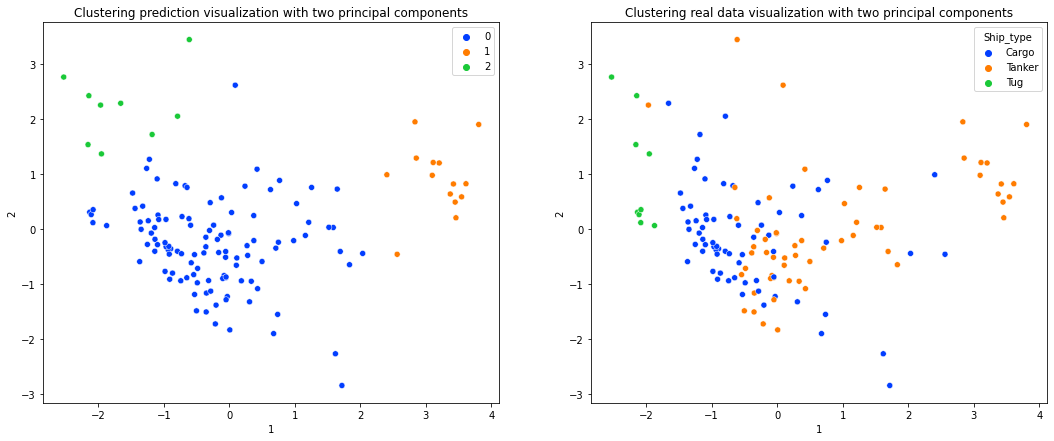

Adjusted rand score: 0.08402613530472655


In [10]:
#Plotting PCA vs predicted labels
fig, axs = plt.subplots(1,2,figsize=(18,7))

sns.scatterplot(x=principal_components_df[1],y= principal_components_df[2], hue = labeldata, palette='bright',ax=axs[0])
axs[0].set_title("Clustering prediction visualization with two principal components")

#Plot with true class labels
sns.scatterplot(x = principal_components_df[1],y = principal_components_df[2], hue = data['Ship_type'], palette='bright',ax=axs[1])
plt.title('Clustering real data visualization with two principal components')
plt.show()    


#Calculate adjusted rand score
rand_score = adjusted_rand_score(data['Ship_type'], labeldata)
print('Adjusted rand score: ' + str(rand_score))

####  Part 3a : Answers here:

The adjusted rand score shows much worse accuracy than the silhouette score. The visualization shows us that all of the tankers in the middle range have all been classified as cargo. This is most likely due to the similarities in size of the ships and is probably hard for the learning algorithms to detect. We would need a more distinguishing feature to separate the ships.

###  Part 3b: Another linkage criterion
 
 - Perform the same steps as in the previous task (3a), but this time using the "complete" linkage criterion. Visualize the clusters (predicted labels vs. the real labels) and compute the adjusted rand score for the predictions.
 
 - Which linkage criterion performs better based on visual inspection and the adjusted rand score? How do the two criteria differ from each other?
 
 - Compare the formulas for adjusted rand score and silhouette score. Can you explain (briefly) why a given linkage criterion can perform relatively well with respect to one metric and badly w.r.t. the other one?

In [11]:
#Linkage criterion 'complete'
X_3 = x
aggcluster_3 = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(X)
labeldata_3 = aggcluster_3.labels_

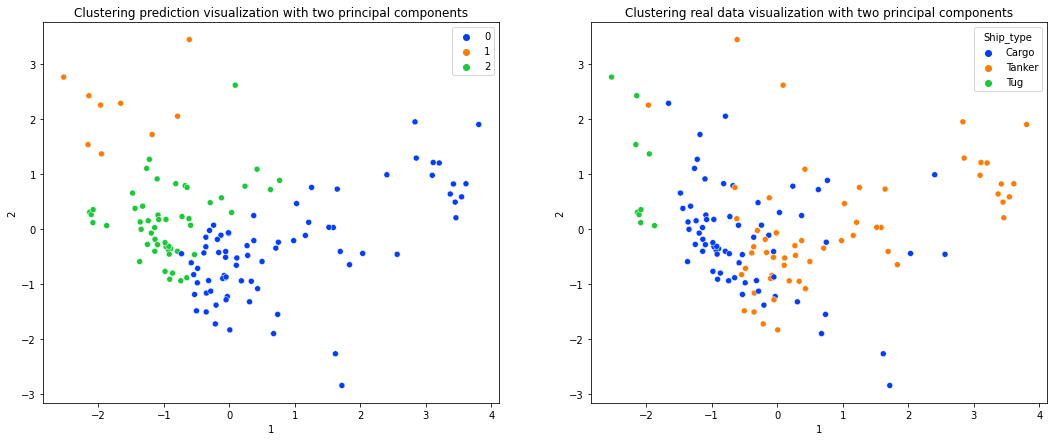

Adjusted rand score: 0.28276078550109063
False


In [12]:
#Plotting PCA vs predicted labels
fig, axs = plt.subplots(1,2,figsize=(18,7))

sns.scatterplot(x=principal_components_df[1],y= principal_components_df[2], hue = labeldata_3, palette='bright',ax=axs[0])
axs[0].set_title("Clustering prediction visualization with two principal components")

#Plot with true class labels
sns.scatterplot(x = principal_components_df[1],y = principal_components_df[2], hue = data['Ship_type'], palette='bright',ax=axs[1])
plt.title('Clustering real data visualization with two principal components')
plt.show()    


#Calculate adjusted rand score
rand_score_3 = adjusted_rand_score(data['Ship_type'], labeldata_3)
print('Adjusted rand score: ' + str(rand_score_3))

print(rand_score == rand_score_3)

####  Part 3b : Answers here:

With this linkage criterion, the silhouette score was worse than the rand score. This is due to the algorithm categorizing the ships in opposite, which makes for better precision, but low accuracy. The agglomerative clustering algorithm with linkage criterion 'complete' can't find the ships at all. 

### Part 4: Plot the dendrogram

 - As the last step, plot dendrograms to visualize the merging processes.
 - For this you will need a linkage matrix - while you can extract one from a fitted AgglomerativeClustering object, it is much easier to use the scipy implementation (scipy.cluster.hierarchy.linkage).
 - Compute the linkage matrix using both average and complete linkage, and plot the dendrograms using scipy.cluster.hierarchy.dendrogram). Truncate the dendrogram so that three levels of the dendrogram tree are visible for better readability.
 - How do you interpret the dendrograms? How do they differ?

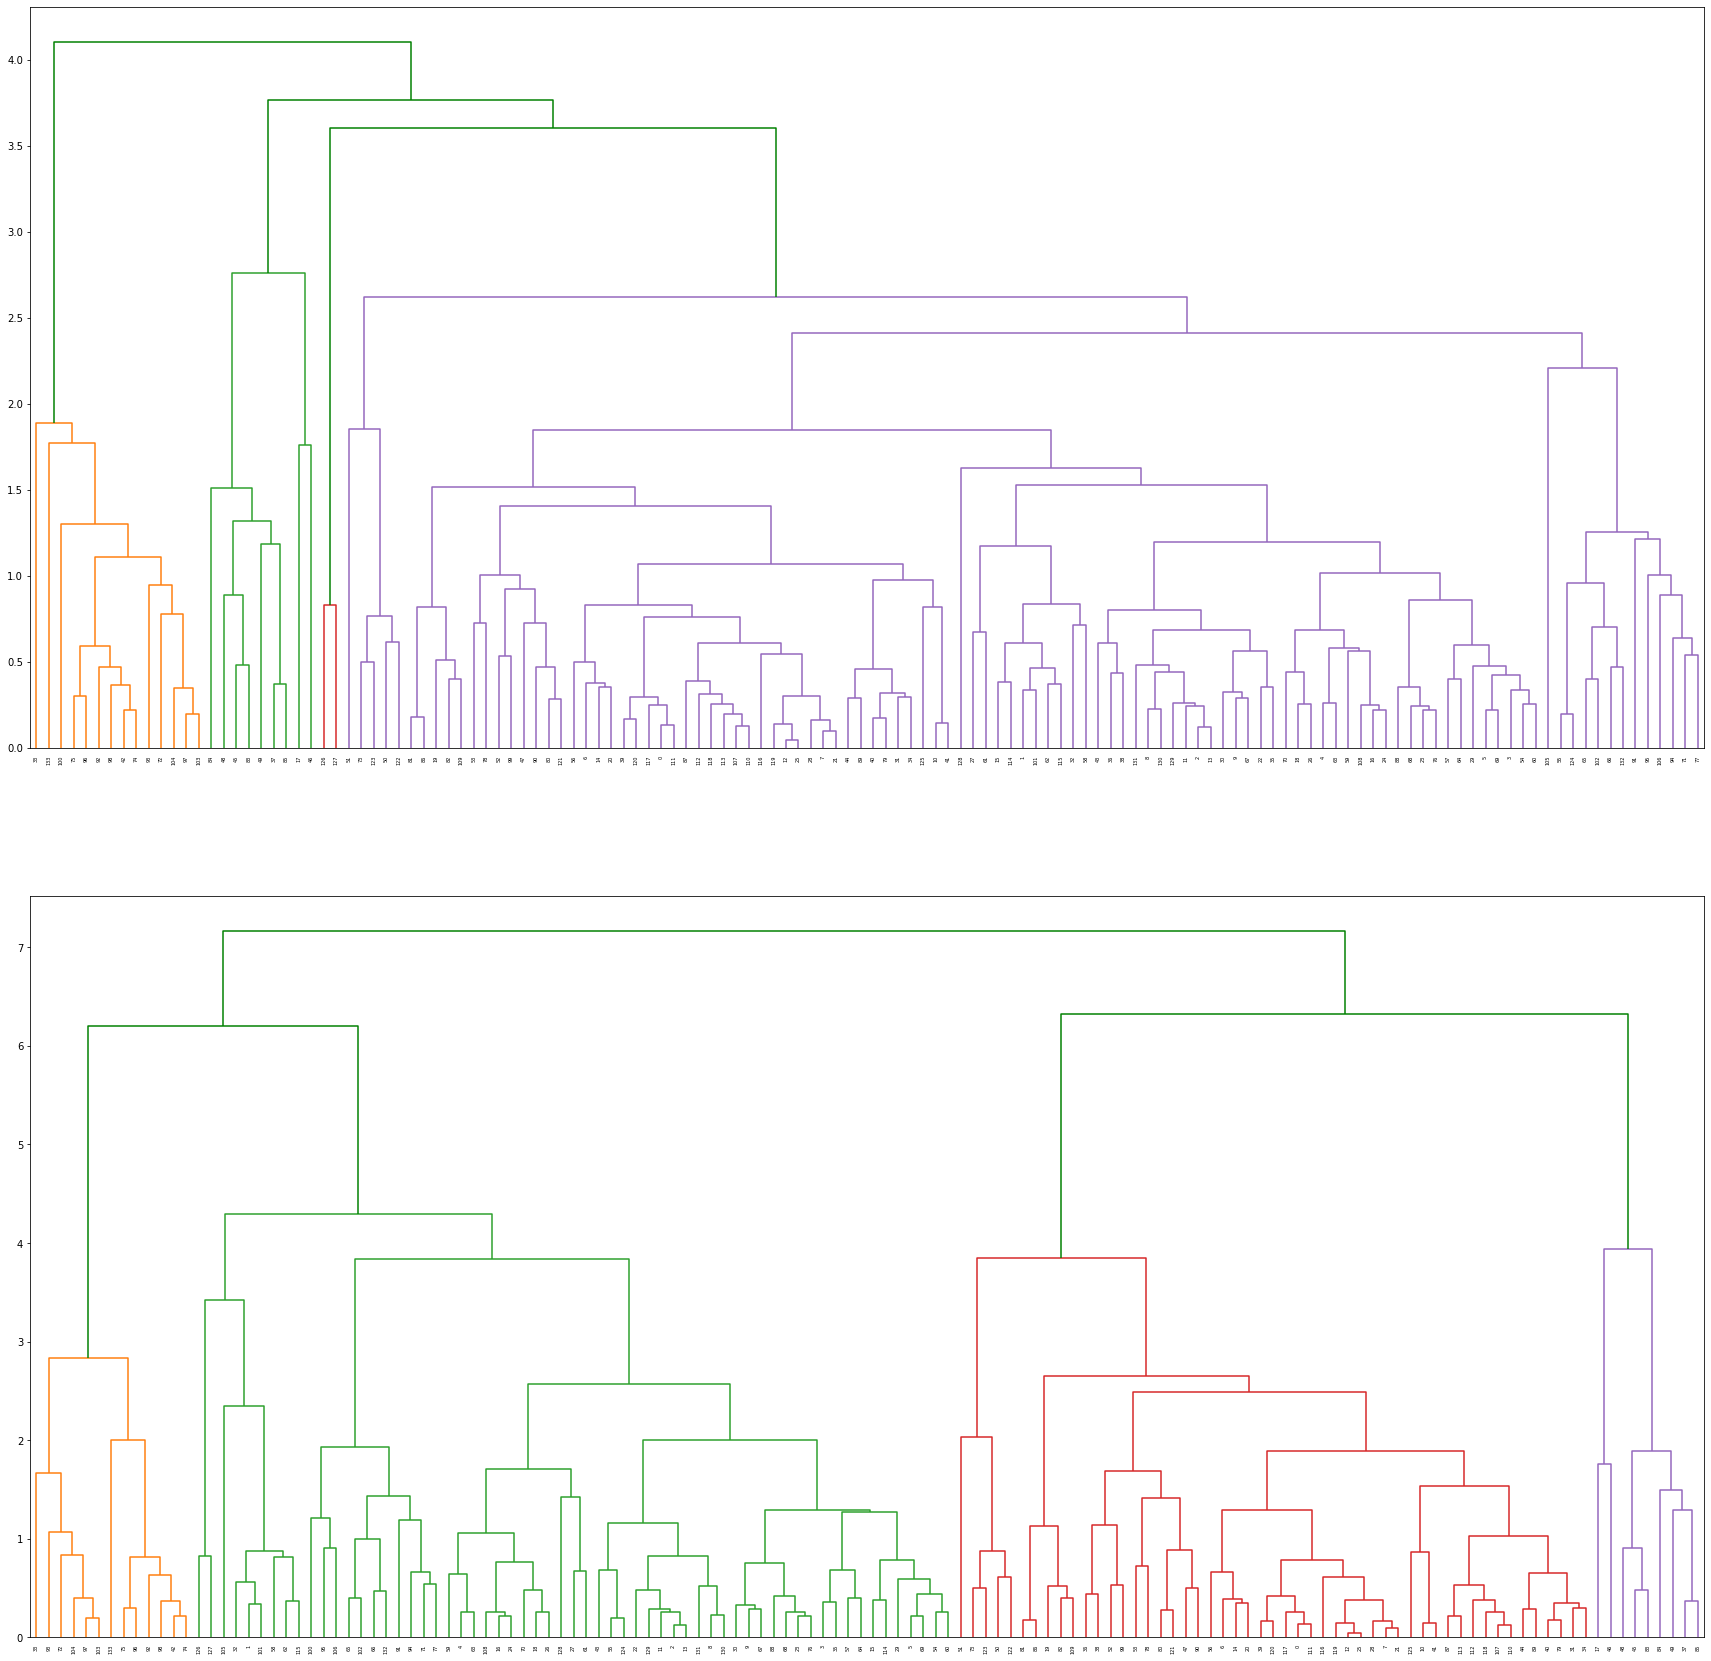

In [28]:
#Linkage matrix
linkage_matrix_1 = linkage(X, 'average')
linkage_matrix_2 = linkage(X, 'complete')

#Dendograms
fig, axs = plt.subplots(2, 1, figsize=(30, 30))

dn1 = dendrogram(linkage_matrix_1, ax=axs[0], above_threshold_color='green',orientation='top')

dn2 = dendrogram(linkage_matrix_2, ax=axs[1], above_threshold_color='green', orientation='top')

####  Part 4 : Answers here:

I am quite sure that this is not how the dendrogram should look like. The linkages can be seen getting smaller and the differences are also visible.

### Part 5 (optional bonus task): Implement K-Means clustering

 - For an extra point (pass with honors i.e. 100 in the 0/50/100 grading scheme), write your <b>own implementation</b> of the K-means clustering algorithm. The bonus point will be granted for a working implementation of the algorithm. It will not be granted for e.g. merely performing clustering using the scikit-learn implementation of K-Means or an unfinished implementation.
 - Visualize the labels predicted by your K-Means implementation against the real labels and compute the adjusted rand index.
 - Compare your K-Means implementation to the scikit-learn implementation. Do you get the same results? If not, why?
 - Remember to comment your code for readability.

In [14]:
# code here...

####  Part 5 : Answers here: